# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)
### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Needed librairies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import gzip
import sys
import _pickle as cPickle

In [2]:
tf.__version__

'1.12.0'

In [147]:
tf.logging.set_verbosity(tf.logging.INFO)

## Import the Data

In [3]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# with AXA network
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [4]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [5]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [6]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [7]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

## Normalize and reorganize the data

In [8]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [9]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [10]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [11]:
x_train.shape

(60000, 784)

In [12]:
x_test.shape

(10000, 784)

## Reshape the labels

In [13]:
y_train.shape

(60000,)

In [14]:
y_test.shape

(10000,)

In [15]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [16]:
num_classes = len(np.unique(y_train))
num_classes

10

In [17]:
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [18]:
y_train.shape

(60000, 10)

In [19]:
y_test.shape

(10000, 10)

In [20]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

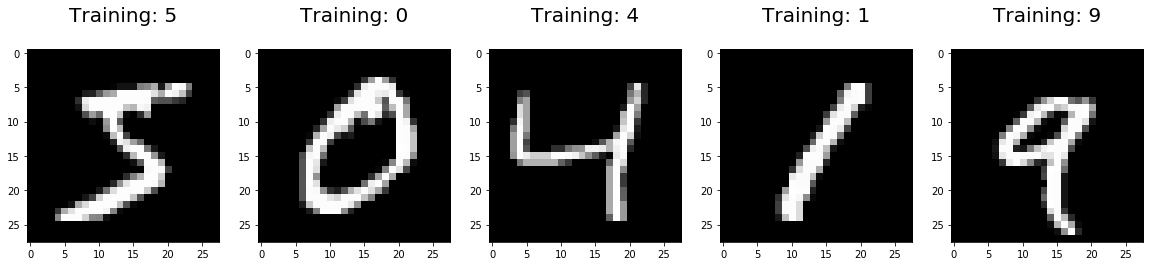

In [21]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Defined some hyperparameters

In [22]:
# learning rate
learning_rate = 0.5

# number of epoch to train our model
EPOCHS = 1

# size of our mini batch
#BATCH_SIZE = len(x_train)
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = 1 #tf.contrib.data.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# hidden layer 1
n1=300

In [23]:
BATCH_SIZE, EPOCHS

(128, 1)

## Defined flags

In [24]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)
    
del_all_flags(tf.flags.FLAGS)

In [25]:
tf.app.flags.DEFINE_string('f', '', 'kernel') # just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
tf.app.flags.DEFINE_string('model_dir', '../results/Models/Mnist/ckpt/', 'Dir to save a model and checkpoints')
tf.app.flags.DEFINE_string('saved_dir', '../results/Models/Mnist/pb/', 'Dir to save a model for TF serving')
tf.app.flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
tf.app.flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
tf.app.flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
tf.app.flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')
FLAGS = tf.app.flags.FLAGS

In [26]:
print(FLAGS)


/Users/tarrade/anaconda3/envs/env_gcp_dl/lib/python3.6/site-packages/ipykernel_launcher.py:
  --batch_size: Batch size
    (default: '128')
    (an integer)
  --f: kernel
    (default: '')
  --model_dir: Dir to save a model and checkpoints
    (default: '../results/Models/Mnist/ckpt/')
  --num_parallel_calls: Number of paralell calls
    (default: '4')
    (an integer)
  --prefetch_buffer_size: Prefetch buffer size
    (default: '1')
    (an integer)
  --saved_dir: Dir to save a model for TF serving
    (default: '../results/Models/Mnist/pb/')
  --shuffle_buffer_size: Shuffle buffer size
    (default: '1280')
    (an integer)

absl.flags:
  --flagfile: Insert flag definitions from the given file into the command line.
    (default: '')
  --undefok: comma-separated list of flag names that it is okay to specify on
    the command line even if the program does not define a flag with that name.
    IMPORTANT: flags in this list that have arguments MUST use the --flag=value
    format.
   

## Using tf.data.Dataset
https://www.tensorflow.org/guide/performance/datasets  
To summarize, one good order for the different transformations is:
- create the dataset
- shuffle (with a big enough buffer size)
- repeat
- map with the actual work (preprocessing, augmentation…) using multiple parallel calls
- batch
- prefetch

ModeKeys:  
https://www.tensorflow.org/api_docs/python/tf/estimator/ModeKeys  
- EVAL
- PREDICT
- TRAIN

In [149]:
def input_dataset_fn(x_data, y_data, batch_size=128, mode=tf.estimator.ModeKeys.TRAIN):
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        tf.logging.info("input_dataset_fn: PREDICT, {}".format(mode))
    elif mode == tf.estimator.ModeKeys.EVAL:
        tf.logging.info("input_dataset_fn: EVAL, {}".format(mode))
    elif mode == tf.estimator.ModeKeys.TRAIN:
        tf.logging.info("input_dataset_fn: TRAIN, {}".format(mode))
    
    # 1) convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    
    # 2) shuffle (with a big enough buffer size)    :        
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # loop indefinitely
        dataset = dataset.shuffle(buffer_size=FLAGS.shuffle_buffer_size, seed=2)# depends on sample size
    else:
        num_epochs = 1 # end-of-input after this
        
    print('the number of epoch: num_epoch =', num_epochs)
        
    # caching data
    #dataset = dataset.cache()
    
    # 3) automatically refill the data queue when empty
    dataset = dataset.repeat(num_epochs)
    
    # 4) map
    #dataset = dataset.map(map_func=parse_fn, num_parallel_calls=FLAGS.num_parallel_calls)

    # 5) create batches of data
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    
    # 6) prefetch data for faster consumption, based on your system and environment, allows the tf.data runtime to automatically tune the prefetch buffer sizes
    dataset = dataset.prefetch(FLAGS.prefetch_buffer_size)

    return dataset

In [150]:
training_dataset = input_dataset_fn(x_train, 
                                    y_train, 
                                    mode=tf.estimator.ModeKeys.TRAIN, 
                                    batch_size=FLAGS.batch_size)
testing_dataset = input_dataset_fn(x_test, 
                                   y_test,
                                   mode=tf.estimator.ModeKeys.EVAL, 
                                   batch_size=len(x_test))

INFO:tensorflow:input_dataset_fn: TRAIN, train
the number of epoch: num_epoch = None
INFO:tensorflow:input_dataset_fn: EVAL, eval
the number of epoch: num_epoch = 1


### exploration dataset API

In [29]:
iterator = training_dataset.make_one_shot_iterator()

In [30]:
# next_element
features, labels = iterator.get_next()

In [31]:
len(x_train)/BATCH_SIZE

468.75

In [32]:
n=0
n_iter=470
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print('iteration n:', n, 'execution time:', time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
            n+=1
            if n>=n_iter:
                print('number of iteration reached')
                break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

iteration n: 0 execution time: 16.705092000000004 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 1 execution time: 0.0023070000000018354 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 2 execution time: 0.0041099999999971715 seconds
(128, 784)
(128, 10)
first label of the batch 6 

iteration n: 3 execution time: 0.003944999999994536 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 4 execution time: 0.003880000000002326 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 5 execution time: 0.002308999999996786 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 6 execution time: 0.002856999999998777 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 7 execution time: 0.0038380000000017844 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 8 execution time: 0.003968000000000416 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration

iteration n: 133 execution time: 0.004493000000003633 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 134 execution time: 0.003923000000000343 seconds
(128, 784)
(128, 10)
first label of the batch 4 

iteration n: 135 execution time: 0.003917000000001281 seconds
(128, 784)
(128, 10)
first label of the batch 7 

iteration n: 136 execution time: 0.0024820000000005393 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 137 execution time: 0.002879999999997551 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 138 execution time: 0.003839000000006365 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 139 execution time: 0.00428200000000345 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 140 execution time: 0.0039420000000021105 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 141 execution time: 0.004848000000002628 seconds
(128, 784)
(128, 10)
first label of the b

iteration n: 266 execution time: 0.004579999999997142 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 267 execution time: 0.004323000000006516 seconds
(128, 784)
(128, 10)
first label of the batch 0 

iteration n: 268 execution time: 0.003909999999997638 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 269 execution time: 0.003943999999997061 seconds
(128, 784)
(128, 10)
first label of the batch 3 

iteration n: 270 execution time: 0.004184000000002186 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 271 execution time: 0.003943999999997061 seconds
(128, 784)
(128, 10)
first label of the batch 3 

iteration n: 272 execution time: 0.006076000000000192 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 273 execution time: 0.005302000000000362 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 274 execution time: 0.0043659999999974275 seconds
(128, 784)
(128, 10)
first label of the b

iteration n: 402 execution time: 0.004202999999996848 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 403 execution time: 0.002780000000001337 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 404 execution time: 0.004043999999993275 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 405 execution time: 0.003398999999994601 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 406 execution time: 0.002453000000002703 seconds
(128, 784)
(128, 10)
first label of the batch 0 

iteration n: 407 execution time: 0.0043199999999998795 seconds
(128, 784)
(128, 10)
first label of the batch 7 

iteration n: 408 execution time: 0.007286999999998045 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 409 execution time: 0.005428999999999462 seconds
(128, 784)
(128, 10)
first label of the batch 6 

iteration n: 410 execution time: 0.004378999999993027 seconds
(128, 784)
(128, 10)
first label of the b

In [33]:
iterator = testing_dataset.make_one_shot_iterator()

In [34]:
# next_element
features, labels = iterator.get_next()

In [35]:
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print(time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

3.5268979999999956 seconds
(10000, 784)
(10000, 10)
first label of the batch 7 

tf.errors.OutOfRangeError


### Keras Call back

In [36]:
class UDFPrint(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        _, __, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        print('Reached epoch {0:3d} cost J = {1:.5f}'.format(epoch, loss_train))
        return

    def on_epoch_end(self, epoch, logs={}):
        x_test, y_test, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        loss_test, acc_test = self.model.evaluate(x_test, y_test, verbose=0)
        print(' accurary on the training set {0:.4f}'.format(acc_train))
        print(' accurary on the testing set {0:.4f}'.format(acc_test))

    def on_batch_begin(self, batch, logs={}):
        #print('  ---> starting minibatch', batch)
        return

    def on_batch_end(self, batch, logs={}):
        #print('  ---> ending minibatch', batch)
        return
return

## Defined our model

In [136]:
def baseline_model():
    # create model
    model = tf.keras.Sequential()
 
    # hidden layer
    model.add(tf.keras.layers.Dense(dim_input, 
                    input_dim=dim_input, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    # last layer
    model.add(tf.keras.layers.Dense(num_classes, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='softmax'))
    
    # weight initialisation
    # He: keras.initializers.he_normal(seed=None)
    # Xavier: keras.initializers.glorot_uniform(seed=None)
    # Radom Normal: keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    # Truncated Normal: keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
    
    # optimiser (use tf.train and not tf.keras to use MirrorStrategy)
    # https://www.tensorflow.org/api_docs/python/tf/train/Optimizer
    optimiser=tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9)
    # GD/SGC:   tf.train.GradientDescentOptimizer(learning_rate, use_locking=False, name='GradientDescent') 
    # Adam:     tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False,name='Adam')
    # RMSProp:  tf.train.RMSPropOptimizer(learning_rate, decay=0.9, momentum=0.0, epsilon=1e-10, use_locking=False, centered=False, name='RMSProp')
    # Momentum: tf.train.MomentumOptimizer(learning_rate, momentum, use_locking=False, name='Momentum', use_nesterov=False)

   
    #optimiser=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9)
    # GD/SGC:   keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    # Adam:     keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # RMSProp:  keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    # Momentum: keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimiser, 
                  metrics=['accuracy'])
    return model

In [137]:
# build the model
model = baseline_model()

In [138]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


In [161]:
model.input_names # Use this name as the dictionary key in the TF input function

['dense_2_input']

In [167]:
model.output_names

['dense_3']

## Store the original weights

In [40]:
initial_weights = model.get_weights()

## Fit the model using numpy array  
- batch_size 
  determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- steps_per_epoch 
  the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- validation_steps 
  similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



In [41]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# Fit the model
hist=model.fit(x_train, 
               y_train, 
               validation_data=(x_test, y_test),
               callbacks=[UDFPrint((x_test, y_test, x_train, y_train))],
               epochs=EPOCHS, 
               batch_size=BATCH_SIZE,
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Reached epoch   0 cost J = 2.38189
Epoch 1/1
 accurary on the training set 0.9671
 accurary on the testing set 0.9622
 - 11s - loss: 0.2109 - acc: 0.9359 - val_loss: 0.1290 - val_acc: 0.9622


In [42]:
print(hist.history)

{'val_loss': [0.1289849532082677], 'val_acc': [0.9622], 'loss': [0.21093945096333822], 'acc': [0.9358833333015442]}


In [43]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12898495245082303
Test accuracy: 0.9622


In [44]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.10361938323254387
Train accuracy: 0.96715


In [162]:
model.save('keras_model.h5')

## Fit the model using data.dataset

In [45]:
len(x_train) //BATCH_SIZE

468

In [46]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# Fit the model (using data.Dataset)
hist=model.fit(training_dataset.make_one_shot_iterator(),
               steps_per_epoch=len(x_train) // BATCH_SIZE,
               validation_data=testing_dataset.make_one_shot_iterator(),
               validation_steps=1, #len(x_test) // BATCH_SIZE,
               #callbacks=[UDFPrint((x_test, y_test, x_train, y_train))],
               epochs=EPOCHS,
               verbose = 2)

Epoch 1/1
 - 30s - loss: 0.2155 - acc: 0.9372 - val_loss: 0.1467 - val_acc: 0.9606


In [47]:
print(hist.history)

{'val_loss': [0.14673830568790436], 'val_acc': [0.9606000185012817], 'loss': [0.2155189816083791], 'acc': [0.9371661324786325]}


In [48]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1467386149774422
Test accuracy: 0.9606


In [49]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.1133710061066784
Train accuracy: 0.9650666666666666


## Fit the model using data.dataset

In [139]:
! rm -r ../results/Models/Mnist/ckpt

In [70]:
!rmdir /S /Q "../results/Models/Mnist/ckpt"

In [140]:
class TimeHistory(tf.train.SessionRunHook):
    def begin(self):
        self.times = []

    def before_run(self, run_context):
        self.iter_time_start = time.time()

    def after_run(self, run_context, run_values):
        self.times.append(time.time() - self.iter_time_start)

In [141]:
time_hist = TimeHistory()

In [142]:
# the tf.distribute.Strategy API is an easy way to distribute your training across multiple devices/machines
NUM_GPUS = 2
#strategy=None
## doesn't work with Keras ?!?
strategy = tf.contrib.distribute.OneDeviceStrategy('device:CPU:0')
#strategy = tf.contrib.distribute.OneDeviceStrategy('device:GPU:0')
#strategy = tf.contrib.distribute.MirroredStrategy(num_gpus=NUM_GPUS)
#strategy = tf.contrib.distribute.MirroredStrategy()

# config tf.estimator to use a give strategy
training_config = tf.estimator.RunConfig(train_distribute=strategy,
                                         model_dir=FLAGS.model_dir,
                                         save_summary_steps=20,
                                         save_checkpoints_steps=20)

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.


In [143]:
# Set to the original weights for testing other pipelines
#model.set_weights(initial_weights)

# transfor keras model to estimator model
estimator_train_model = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                              config=training_config)

INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '../results/Models/Mnist/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 20, '_save_checkpoints_steps': 20, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0xb55170518>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb55170588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_distribute_coordinator_mode

In [144]:
!ls ../results/Models/Mnist/ckpt

keras


In [83]:
!dir /B "../results/Models/Mnist/ckpt"

keras


### Training our model

In [145]:
def get_train_input_fn():
    return input_dataset_fn(x_train,
                            y_train, 
                            mode=tf.estimator.ModeKeys.TRAIN, 
                            batch_size=FLAGS.batch_size)

In [156]:
# Fit the model (using estimator.train and data.Dataset)
#estimator_train_model.train(input_fn=lambda:input_dataset_fn(x_train, y_train, is_training=True, batch_size=BATCH_SIZE),
#                            max_steps=1,
#                            hooks=[time_hist])
estimator_train_model.train(input_fn=get_train_input_fn,
                            #max_steps=1,
                            steps=10,
                            hooks=[time_hist])

INFO:tensorflow:input_dataset_fn: TRAIN, train
the number of epoch: num_epoch = None
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='../results/Models/Mnist/ckpt/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('../results/Models/Mnist/ckpt/keras/keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: dense_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_3/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_3/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-10
INFO:tensorflow:Running local_

In [155]:
total_time = sum(time_hist.times)
print(f"total time with the current strategy: {total_time} seconds")

total time with the current strategy: 1.1151227951049805 seconds


In [160]:
avg_time_per_batch = np.mean(time_hist.times)
print(f"{BATCH_SIZE/avg_time_per_batch} images/second")

983.0330400492771 images/second


### Evaluating the accuracy of our model

In [157]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_train,y_train, mode=tf.estimator.ModeKeys.TRAIN, batch_size=len(y_train)),
                                    steps=1)

INFO:tensorflow:input_dataset_fn: TRAIN, train
the number of epoch: num_epoch = None
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-23-20:44:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-20
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-01-23-20:44:24
INFO:tensorflow:Saving dict for global step 20: accuracy = 0.8536, global_step = 20, loss = 0.50592864
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 20: ../results/Models/Mnist/ckpt/model.ckpt-20


In [66]:
score

{'accuracy': 0.9609, 'loss': 0.14206357, 'global_step': 10}

In [81]:
print('Train loss:', score['loss'])
print('Train accuracy:', score['accuracy'])
print('Train global steps:', score['global_step'])

Train loss: 0.17138538
Train accuracy: 0.9535
Train global steps: 10


In [82]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_test, y_test,mode=tf.estimator.ModeKeys.EVAL, batch_size=len(x_test)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-23-15:22:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-23-15:22:58
INFO:tensorflow:Saving dict for global step 10: accuracy = 0.9535, global_step = 10, loss = 0.1713854
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10: ../results/Models/Mnist/ckpt/model.ckpt-10


In [83]:
print('Test loss:', score['loss'])
print('Test accuracy:', score['accuracy'])
print('Test global steps:', score['global_step'])

Test loss: 0.1713854
Test accuracy: 0.9535
Test global steps: 10


### Generating predictions on our trained model

In [104]:
predictions=list(estimator_train_model.predict(input_fn=lambda:input_dataset_fn(x_test, y_test,mode=tf.estimator.ModeKeys.EVAL, batch_size=len(x_test))))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [102]:
len(predictions)

10000

In [186]:
predictions[0]

{'dense_1': array([1.9695989e-14, 3.4005119e-08, 2.7797466e-07, 1.2650125e-08,
        4.3470757e-18, 2.3806969e-11, 6.0802081e-21, 9.9999964e-01,
        5.8391830e-15, 2.6611329e-11], dtype=float32)}

In [101]:
for i in range(len(predictions)):
    prediction_array = predictions[i]['dense_1']
    predicted_label = np.argmax(prediction_array)
    print('Actual label:', np.argmax(y_test[i]))
    print("Predicted label: ", predicted_label)

Actual label: 7
Predicted label:  7
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 0
Predicted label:  0
Actual label: 4
Predicted label:  4
Actual label: 1
Predicted label:  1
Actual label: 4
Predicted label:  4
Actual label: 9
Predicted label:  9
Actual label: 5
Predicted label:  5
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  0
Actual label: 6
Predicted label:  6
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 5
Predicted label:  5
Actual label: 9
Predicted label:  9
Actual label: 7
Predicted label:  7
Actual label: 3
Predicted label:  3
Actual label: 4
Predicted label:  4
Actual label: 9
Predicted label:  9
Actual label: 6
Predicted label:  6
Actual label: 6
Predicted label:  6
Actual label: 5
Predicted label:  5
Actual label: 4
Predicted label:  4
Actual label: 0
Predicted label:  0
Actual label: 7
Predicted label:  7
Actual label: 4
Predicted la

Predicted label:  6
Actual label: 3
Predicted label:  3
Actual label: 5
Predicted label:  5
Actual label: 4
Predicted label:  4
Actual label: 8
Predicted label:  8
Actual label: 3
Predicted label:  3
Actual label: 3
Predicted label:  3
Actual label: 9
Predicted label:  9
Actual label: 3
Predicted label:  3
Actual label: 3
Predicted label:  3
Actual label: 3
Predicted label:  2
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 0
Predicted label:  0
Actual label: 8
Predicted label:  2
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 7
Predicted label:  7
Actual label: 0
Predicted label:  0
Actual label: 6
Predicted label:  6
Actual label: 5
Predicted label:  5
Actual label: 4
Predicted label:  4
Actual label: 3
Predicted label:  3
Actual label: 8
Predicted label:  3
Actual label: 0
Predicted label:  0
Actual label: 9
Predicted label:  9
Actual label: 6
Predicted label:  6
Actual label: 3
Predicted label:  3
Actual l

Actual label: 5
Predicted label:  5
Actual label: 0
Predicted label:  0
Actual label: 9
Predicted label:  9
Actual label: 2
Predicted label:  2
Actual label: 2
Predicted label:  2
Actual label: 4
Predicted label:  4
Actual label: 8
Predicted label:  8
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 7
Predicted label:  7
Actual label: 2
Predicted label:  2
Actual label: 4
Predicted label:  4
Actual label: 9
Predicted label:  9
Actual label: 4
Predicted label:  4
Actual label: 4
Predicted label:  4
Actual label: 0
Predicted label:  0
Actual label: 3
Predicted label:  7
Actual label: 9
Predicted label:  9
Actual label: 2
Predicted label:  2
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 3
Predicted label:  3
Actual label: 8
Predicted label:  4
Actual label: 3
Predicted label:  3
Actual label: 5
Predicted label:  5
Actual label: 7
Predicted label:  7
Actual label: 3
Predicted label:  3
Actual label: 5
Predicted la

Predicted label:  0
Actual label: 1
Predicted label:  5
Actual label: 1
Predicted label:  1
Actual label: 4
Predicted label:  4
Actual label: 8
Predicted label:  7
Actual label: 3
Predicted label:  5
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  0
Actual label: 0
Predicted label:  0
Actual label: 0
Predicted label:  0
Actual label: 6
Predicted label:  6
Actual label: 6
Predicted label:  6
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 4
Predicted label:  4
Actual label: 7
Predicted label:  7
Actual label: 7
Predicted label:  7
Actual label: 9
Predicted label:  9
Actual label: 2
Predicted label:  2
Actual label: 4
Predicted label:  4
Actual label: 1
Predicted label:  1
Actual label: 4
Predicted label:  6
Actual label: 5
Predicted label:  5
Actual label: 2
Predicted label:  2
Actual label: 4
Predicted label:  4
Actual label: 9
Predicted label:  5
Actual l

Actual label: 8
Predicted label:  8
Actual label: 4
Predicted label:  9
Actual label: 9
Predicted label:  9
Actual label: 2
Predicted label:  2
Actual label: 8
Predicted label:  8
Actual label: 6
Predicted label:  6
Actual label: 2
Predicted label:  2
Actual label: 7
Predicted label:  7
Actual label: 0
Predicted label:  0
Actual label: 0
Predicted label:  0
Actual label: 6
Predicted label:  6
Actual label: 7
Predicted label:  7
Actual label: 5
Predicted label:  5
Actual label: 8
Predicted label:  8
Actual label: 6
Predicted label:  6
Actual label: 0
Predicted label:  0
Actual label: 9
Predicted label:  9
Actual label: 3
Predicted label:  3
Actual label: 7
Predicted label:  9
Actual label: 1
Predicted label:  1
Actual label: 3
Predicted label:  3
Actual label: 5
Predicted label:  5
Actual label: 4
Predicted label:  4
Actual label: 3
Predicted label:  3
Actual label: 3
Predicted label:  3
Actual label: 5
Predicted label:  5
Actual label: 5
Predicted label:  5
Actual label: 6
Predicted la

Actual label: 4
Predicted label:  4
Actual label: 8
Predicted label:  8
Actual label: 4
Predicted label:  4
Actual label: 5
Predicted label:  5
Actual label: 8
Predicted label:  8
Actual label: 3
Predicted label:  5
Actual label: 0
Predicted label:  0
Actual label: 6
Predicted label:  6
Actual label: 2
Predicted label:  2
Actual label: 7
Predicted label:  7
Actual label: 3
Predicted label:  3
Actual label: 3
Predicted label:  3
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 0
Predicted label:  0
Actual label: 7
Predicted label:  7
Actual label: 3
Predicted label:  3
Actual label: 4
Predicted label:  4
Actual label: 0
Predicted label:  6
Actual label: 3
Predicted label:  3
Actual label: 9
Predicted label:  9
Actual label: 3
Predicted label:  3
Actual label: 2
Predicted label:  2
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  0
Actual label: 3
Predicted label:  3
Actual label: 8
Predicted la

Predicted label:  2
Actual label: 6
Predicted label:  6
Actual label: 2
Predicted label:  2
Actual label: 7
Predicted label:  7
Actual label: 1
Predicted label:  1
Actual label: 7
Predicted label:  7
Actual label: 9
Predicted label:  9
Actual label: 4
Predicted label:  4
Actual label: 0
Predicted label:  0
Actual label: 0
Predicted label:  0
Actual label: 3
Predicted label:  3
Actual label: 8
Predicted label:  8
Actual label: 2
Predicted label:  2
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 1
Predicted label:  1
Actual label: 6
Predicted label:  6
Actual label: 0
Predicted label:  0
Actual label: 5
Predicted label:  5
Actual label: 7
Predicted label:  7
Actual label: 7
Predicted label:  7
Actual label: 9
Predicted label:  9
Actual label: 2
Predicted label:  2
Actual label: 6
Predicted label:  6
Actual label: 7
Predicted label:  7
Actual label: 9
Predicted label:  7
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  6
Actual l

Actual label: 3
Predicted label:  3
Actual label: 7
Predicted label:  7
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 8
Predicted label:  8
Actual label: 0
Predicted label:  0
Actual label: 7
Predicted label:  7
Actual label: 1
Predicted label:  1
Actual label: 9
Predicted label:  9
Actual label: 8
Predicted label:  8
Actual label: 7
Predicted label:  7
Actual label: 5
Predicted label:  5
Actual label: 5
Predicted label:  5
Actual label: 9
Predicted label:  9
Actual label: 1
Predicted label:  1
Actual label: 7
Predicted label:  7
Actual label: 5
Predicted label:  5
Actual label: 4
Predicted label:  4
Actual label: 9
Predicted label:  3
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 6
Predicted label:  6
Actual label: 6
Predicted label:  6
Actual label: 7
Predicted label:  4
Actual label: 1
Predicted label:  1
Actual label: 1
Predicted la

Predicted label:  6
Actual label: 0
Predicted label:  0
Actual label: 7
Predicted label:  7
Actual label: 3
Predicted label:  3
Actual label: 1
Predicted label:  1
Actual label: 8
Predicted label:  8
Actual label: 3
Predicted label:  3
Actual label: 9
Predicted label:  9
Actual label: 7
Predicted label:  7
Actual label: 0
Predicted label:  0
Actual label: 0
Predicted label:  0
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  4
Actual label: 5
Predicted label:  5
Actual label: 9
Predicted label:  9
Actual label: 8
Predicted label:  8
Actual label: 3
Predicted label:  3
Actual label: 2
Predicted label:  2
Actual label: 7
Predicted label:  2
Actual label: 2
Predicted label:  2
Actual label: 9
Predicted label:  9
Actual label: 7
Predicted label:  7
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 1
Predicted label:  1
Actual label: 3
Predicted label:  3
Actual label: 7
Predicted label:  2
Actual label: 5
Predicted label:  5
Actual l

Predicted label:  9
Actual label: 5
Predicted label:  5
Actual label: 1
Predicted label:  1
Actual label: 3
Predicted label:  3
Actual label: 9
Predicted label:  9
Actual label: 6
Predicted label:  6
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 4
Predicted label:  4
Actual label: 1
Predicted label:  1
Actual label: 7
Predicted label:  7
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 7
Predicted label:  7
Actual label: 9
Predicted label:  9
Actual label: 7
Predicted label:  7
Actual label: 4
Predicted label:  4
Actual label: 9
Predicted label:  9
Actual label: 9
Predicted label:  9
Actual label: 3
Predicted label:  3
Actual label: 9
Predicted label:  9
Actual label: 2
Predicted label:  2
Actual label: 8
Predicted label:  8
Actual label: 2
Predicted label:  2
Actual label: 7
Predicted label:  7
Actual label: 1
Predicted label:  1
Actual label: 8
Predicted label:  8
Actual l

Actual label: 9
Predicted label:  9
Actual label: 4
Predicted label:  4
Actual label: 3
Predicted label:  3
Actual label: 9
Predicted label:  9
Actual label: 6
Predicted label:  6
Actual label: 0
Predicted label:  0
Actual label: 4
Predicted label:  4
Actual label: 0
Predicted label:  0
Actual label: 6
Predicted label:  6
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  5
Actual label: 4
Predicted label:  4
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  5
Actual label: 4
Predicted label:  4
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted la

Predicted label:  6
Actual label: 8
Predicted label:  8
Actual label: 5
Predicted label:  5
Actual label: 5
Predicted label:  5
Actual label: 5
Predicted label:  5
Actual label: 3
Predicted label:  5
Actual label: 5
Predicted label:  5
Actual label: 9
Predicted label:  9
Actual label: 7
Predicted label:  7
Actual label: 4
Predicted label:  4
Actual label: 8
Predicted label:  8
Actual label: 5
Predicted label:  5
Actual label: 9
Predicted label:  9
Actual label: 6
Predicted label:  6
Actual label: 9
Predicted label:  9
Actual label: 3
Predicted label:  3
Actual label: 0
Predicted label:  0
Actual label: 3
Predicted label:  3
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  9
Actual label: 1
Predicted label:  1
Actual label: 8
Predicted label:  8
Actual label: 1
Predicted label:  1
Actual label: 6
Predicted label:  6
Actual label: 0
Predicted label:  0
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual l

Predicted label:  9
Actual label: 4
Predicted label:  4
Actual label: 7
Predicted label:  7
Actual label: 7
Predicted label:  7
Actual label: 9
Predicted label:  9
Actual label: 9
Predicted label:  0
Actual label: 3
Predicted label:  5
Actual label: 4
Predicted label:  4
Actual label: 4
Predicted label:  4
Actual label: 3
Predicted label:  3
Actual label: 8
Predicted label:  8
Actual label: 6
Predicted label:  6
Actual label: 2
Predicted label:  2
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 4
Predicted label:  4
Actual label: 5
Predicted label:  5
Actual label: 6
Predicted label:  6
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 4
Predicted label:  4
Actual l

Actual label: 8
Predicted label:  8
Actual label: 6
Predicted label:  6
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  5
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 4
Predicted label:  4
Actual label: 5
Predicted label:  5
Actual label: 6
Predicted label:  6
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 4
Predicted label:  4
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  8
Actual label: 1
Predicted label:  1
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  9
Actual label: 9
Predicted la

Predicted label:  4
Actual label: 5
Predicted label:  5
Actual label: 6
Predicted label:  6
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  9
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 4
Predicted label:  4
Actual label: 5
Predicted label:  5
Actual label: 6
Predicted label:  6
Actual label: 7
Predicted label:  7
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 4
Predicted label:  4
Actual label: 5
Predicted label:  5
Actual label: 6
Predicted label:  6
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  9
Actual label: 8
Predicted label:  8
Actual label: 4
Predicted label:  4
Actual label: 0
Predicted label:  0
Actual label: 0
Predicted label:  0
Actual label: 7
Predicted label:  7
Actual l

Predicted label:  0
Actual label: 4
Predicted label:  4
Actual label: 6
Predicted label:  6
Actual label: 0
Predicted label:  0
Actual label: 9
Predicted label:  9
Actual label: 1
Predicted label:  1
Actual label: 6
Predicted label:  6
Actual label: 2
Predicted label:  2
Actual label: 7
Predicted label:  7
Actual label: 6
Predicted label:  6
Actual label: 8
Predicted label:  8
Actual label: 3
Predicted label:  3
Actual label: 5
Predicted label:  5
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 8
Predicted label:  8
Actual label: 3
Predicted label:  3
Actual label: 8
Predicted label:  8
Actual label: 6
Predicted label:  6
Actual label: 1
Predicted label:  1
Actual label: 0
Predicted label:  0
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 4
Predicted label:  4
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual l

Actual label: 6
Predicted label:  6
Actual label: 6
Predicted label:  6
Actual label: 8
Predicted label:  8
Actual label: 7
Predicted label:  7
Actual label: 4
Predicted label:  4
Actual label: 2
Predicted label:  2
Actual label: 9
Predicted label:  9
Actual label: 7
Predicted label:  7
Actual label: 0
Predicted label:  0
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 0
Predicted label:  0
Actual label: 3
Predicted label:  8
Actual label: 6
Predicted label:  6
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 4
Predicted label:  4
Actual label: 5
Predicted label:  5
Actual label: 6
Predicted label:  6
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted la

Predicted label:  5
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 9
Predicted label:  9
Actual label: 1
Predicted label:  1
Actual label: 5
Predicted label:  5
Actual label: 1
Predicted label:  1
Actual label: 7
Predicted label:  7
Actual label: 6
Predicted label:  6
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 6
Predicted label:  6
Actual label: 8
Predicted label:  8
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 4
Predicted label:  4
Actual label: 5
Predicted label:  5
Actual label: 6
Predicted label:  6
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  0
Actual l

Predicted label:  3
Actual label: 1
Predicted label:  1
Actual label: 3
Predicted label:  3
Actual label: 2
Predicted label:  2
Actual label: 7
Predicted label:  7
Actual label: 3
Predicted label:  3
Actual label: 1
Predicted label:  1
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 1
Predicted label:  1
Actual label: 3
Predicted label:  3
Actual label: 5
Predicted label:  5
Actual label: 0
Predicted label:  0
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 1
Predicted label:  1
Actual label: 5
Predicted label:  5
Actual label: 1
Predicted label:  1
Actual label: 4
Predicted label:  4
Actual label: 6
Predicted label:  6
Actual label: 0
Predicted label:  0
Actual label: 0
Predicted label:  0
Actual label: 4
Predicted label:  4
Actual label: 9
Predicted label:  9
Actual label: 1
Predicted label:  1
Actual label: 6
Predicted label:  6
Actual label: 6
Predicted label:  6
Actual l

Predicted label:  4
Actual label: 0
Predicted label:  0
Actual label: 9
Predicted label:  9
Actual label: 9
Predicted label:  9
Actual label: 6
Predicted label:  6
Actual label: 1
Predicted label:  1
Actual label: 8
Predicted label:  8
Actual label: 3
Predicted label:  3
Actual label: 3
Predicted label:  3
Actual label: 7
Predicted label:  7
Actual label: 3
Predicted label:  3
Actual label: 9
Predicted label:  9
Actual label: 8
Predicted label:  8
Actual label: 8
Predicted label:  8
Actual label: 4
Predicted label:  4
Actual label: 7
Predicted label:  7
Actual label: 7
Predicted label:  7
Actual label: 6
Predicted label:  6
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 9
Predicted label:  9
Actual label: 8
Predicted label:  8
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 8
Predicted label:  8
Actual label: 7
Predicted label:  7
Actual label: 2
Predicted label:  2
Actual label: 2
Predicted label:  2
Actual l

Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 4
Predicted label:  4
Actual label: 5
Predicted label:  5
Actual label: 6
Predicted label:  6
Actual label: 7
Predicted label:  7
Actual label: 8
Predicted label:  8
Actual label: 9
Predicted label:  9
Actual label: 0
Predicted label:  0
Actual label: 1
Predicted label:  1
Actual label: 2
Predicted label:  2
Actual label: 3
Predicted label:  3
Actual label: 4
Predicted label:  4
Actual label: 5
Predicted label:  5
Actual label: 6
Predicted label:  6


## Model serving

In [177]:
estimator_train_model.params

{}

In [178]:
estimator_train_model.get_variable_names()

['dense_2/bias',
 'dense_2/bias/Adam',
 'dense_2/bias/Adam_1',
 'dense_2/kernel',
 'dense_2/kernel/Adam',
 'dense_2/kernel/Adam_1',
 'dense_3/bias',
 'dense_3/bias/Adam',
 'dense_3/bias/Adam_1',
 'dense_3/kernel',
 'dense_3/kernel/Adam',
 'dense_3/kernel/Adam_1',
 'global_step',
 'training/TFOptimizer/beta1_power',
 'training/TFOptimizer/beta2_power']

In [174]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders#

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    input_images = tf.placeholder(tf.float32, [None, 784])
    features = {'dense_2_input' : input_images} # this is the dict that is then passed as "features" parameter to your model_fn
    receiver_tensors = {'dense_2_input': input_images} # As far as I understand this is needed to map the input to a name you can retrieve later
   
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [175]:
estimator_train_model.export_saved_model(FLAGS.saved_dir, serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-20
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ../results/Models/Mnist/pb/temp-b'1548280036'/saved_model.pb


b'../results/Models/Mnist/pb/1548280036'